# Homework 5 solutions

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.integrate
import time

## Adaptive Runge Kutta integration of orbits

In [11]:
def rk4_step(t, dt, x, derivs):
    f = derivs(t, x)
    f1 = derivs(t + dt/2, x + f*dt/2)
    f2 = derivs(t + dt/2, x + f1*dt/2)
    f3 = derivs(t+dt, x + f2*dt)
    return x + dt*(f + 2*f1 + 2*f2 + f3)/6

def rk4_driver(dt, t_end, x_start, derivs, tol=1e-6):
    x = np.array([x_start])
    tvec = np.array([])
    t = 0.0
    tvec = np.append(tvec,t)
    
    while t < t_end:

        while True:
            x1 = rk4_step(t, dt, x[-1], derivs)
            x2 = rk4_step(t, dt/2, x[-1], derivs)
            x3 = rk4_step(t, dt/2, x2, derivs)
            err = max(abs((x3-x1)))

            if err < tol:
                t = t + dt
                tvec = np.append(tvec,t)
                dt = dt * 2
                # check to see whether this step size would
                # take us beyond t=t_end and if so adjust accordingly
                if t + dt > t_end:
                    dt = t_end - t
                # store the more accurate (2-step) result
                x = np.row_stack((x, x3))
                break
            else:
                dt = dt / 2
                
    return tvec, x

In [12]:
def derivs_orbit(t, x):
    rr = (x[0]**2 + x[1]**2)**0.5
    vxdot = -x[0]/rr**3
    vydot = -x[1]/rr**3
    xdot = x[2]
    ydot = x[3]
    return np.array((xdot,ydot,vxdot,vydot))

number of integration points = 125
integrated to t/2pi=1
start to end differences: [ 9.81260632e-07 -5.15549565e-07  6.00980559e-07 -1.14780523e-07]
vmin=0.229416, vmax=4.3589
rmin=0.1, rmax=1.9
eccentricity of the orbit = 0.9


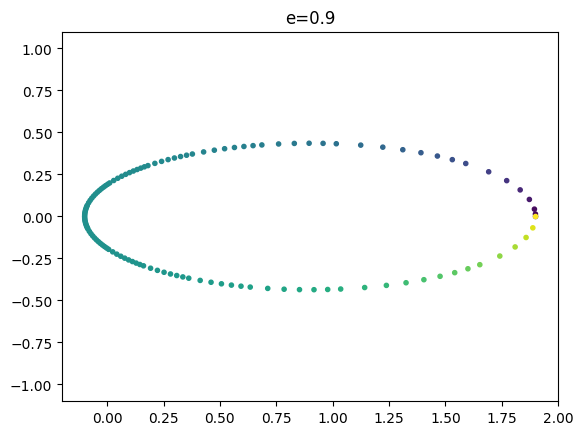

In [14]:
r = 1.9 # starting radius  = 1+e
nsteps = 100
dt = 2 * np.pi / (nsteps-1)
t = np.arange(nsteps)*dt
x_start = np.array((r,0,0,np.sqrt((2/r)-1)))
t4, x4 = rk4_driver(dt, 2*np.pi, x_start, derivs_orbit, tol=1e-6)

print('number of integration points = %d' % (len(x4,)))
print('integrated to t/2pi=%lg' % (t4[-1]/(2*np.pi)))

print('start to end differences:', x4[0]-x4[-1])

v = np.sqrt(x4[:,2]**2 + x4[:,3]**2)
print('vmin=%g, vmax=%lg' % (min(v), max(v)))
r = np.sqrt(x4[:,0]**2 + x4[:,1]**2)
print('rmin=%g, rmax=%lg' % (min(r), max(r)))

e = (max(r)-min(r))/2
print('eccentricity of the orbit = %lg' % (e,))

cols = 255 * t4/max(t4)

x = x4[:,0]
y = x4[:,1]

plt.scatter(x, y, marker = '.', c=cols.astype(int).tolist())
plt.title(r'e=%.3lg' % (e,))

plt.xlim((-(1-e)-0.1,1+e+0.1))
plt.ylim((-1.1,1.1))
plt.show()

## Method of lines

Time taken =  0.04824519157409668


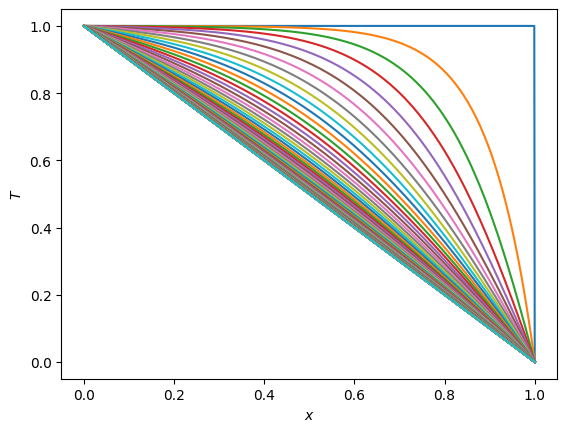

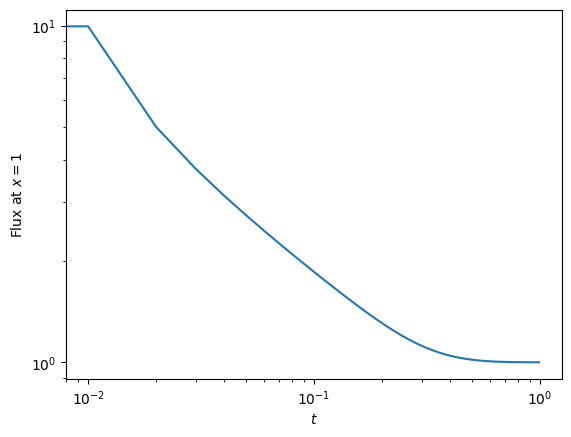

In [8]:
def calculate_A(n, h, banded = True):
    # calculate the matrix A = 1+Ch
    # represented in banded form
    b = (1+2*h)*np.ones(n)
    a = -h*np.ones(n)
    c = -h*np.ones(n)
    c[-1] = 0.0
    a[0] = 0.0
    # boundary conditions: the temperatures at the ends are fixed
    # so we need to adjust the matrix to give T_end^(n+1) = T_end^n
    # x=0
    b[0] = 1.0
    a[1] = 0.0
    # x=1
    b[-1] = 1.0
    c[-2] = 0.0

    if banded:
        AA = np.row_stack((a,b,c))
    else:
        AA = np.diag(b, k=0) + np.diag(a[1:], k=1) + np.diag(c[:-1], k=-1)
    return AA

t0 = time.time()

n = 1001
x = np.linspace(0, 1, n)

# Initial profile has T=1 everywhere except T=0 at the outer boundary
T = np.ones(n)
T[-1] = 0.0

plt.plot(x, T)
plt.xlabel(r'$x$')
plt.ylabel(r'$T$')

dx = x[1]-x[0]
dt = 1e-2
h = dt/dx**2
nsteps = 100

AA = calculate_A(n, h)

# store the gradient at the top
F = np.zeros(nsteps)
F[0] = -(T[-1]-T[-2])

for i in range(1,nsteps):
    T = scipy.linalg.solve_banded((1,1), AA, T)
    F[i] = -(T[-1]-T[-2])/dx
    plt.plot(x, T)

print('Time taken = ', time.time()-t0)
plt.show()

plt.clf()
plt.plot(np.arange(nsteps)*dt, F)
plt.xlabel(r'$t$')
plt.ylabel(r'Flux at $x=1$')
plt.yscale('log')
plt.xscale('log')
plt.show()

Time taken =  3.473201274871826


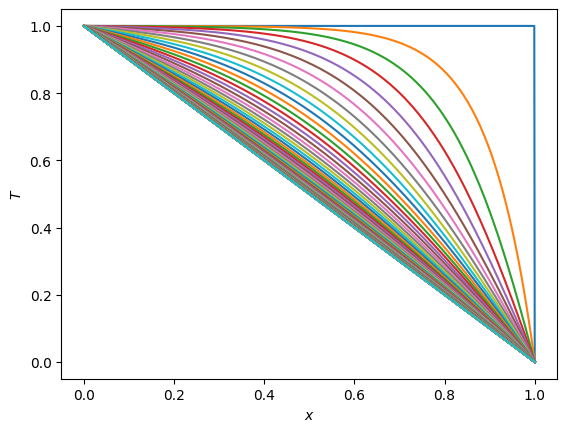

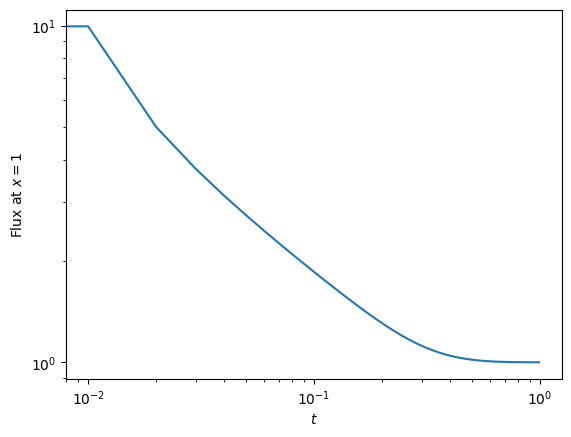

In [9]:
# Repeat but now calculate the full matrix inverse instead of using tridiagonal solver

t0 = time.time()

# Initial profile has T=1 everywhere except T=0 at the outer boundary
T = np.ones(n)
T[-1] = 0.0

plt.plot(x, T)
plt.xlabel(r'$x$')
plt.ylabel(r'$T$')

AA = calculate_A(n, h, banded=False)

# store the gradient at the top
F = np.zeros(nsteps)
F[0] = -(T[-1]-T[-2])

for i in range(1,nsteps):
    Ainv = np.linalg.inv(AA)
    T = Ainv@T
    F[i] = -(T[-1]-T[-2])/dx
    plt.plot(x, T)

print('Time taken = ', time.time()-t0)
plt.show()

plt.clf()
plt.plot(np.arange(nsteps)*dt, F)
plt.xlabel(r'$t$')
plt.ylabel(r'Flux at $x=1$')
plt.yscale('log')
plt.xscale('log')
plt.show()